In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import time
from numpy import array, dot
from qpsolvers import solve_qp

# ✅ Step 1: Download Stock Data with Delay to Prevent Rate Limits
tickers = ["AAPL", "MSFT", "JPM", "V", "GS", "AXP", "UNH", "HD", "MCD", "CAT"]
data_frames = {}

print("Downloading stock data with delay to avoid rate limits...")

for ticker in tickers:
    try:
        print(f"Fetching data for {ticker}...")
        df = yf.download(ticker, start="2000-01-01", end="2025-02-05", progress=False, auto_adjust=True)
        if not df.empty:
            data_frames[ticker] = df["Close"]
        time.sleep(5)  # Wait 5 seconds to avoid rate limiting
    except Exception as e:
        print(f"Failed to fetch {ticker}: {e}")

# Combine all downloaded stock data
if not data_frames:
    raise ValueError("Error: No stock data downloaded. Check Yahoo Finance API or try again later.")

tickers_df = pd.DataFrame(data_frames)

# ✅ Step 2: Compute Log Returns (Ensure `Close` Prices Exist)
if tickers_df.empty:
    raise ValueError("Error: No stock data available after download.")

returns = np.log(tickers_df / tickers_df.shift(1)).dropna()

# ✅ Step 3: Handle Missing Data
returns = returns.dropna()

if returns.empty:
    raise ValueError("Error: The `returns` DataFrame is empty after removing NaN values.")

# ✅ Step 4: Compute Annualized Returns & Covariance Matrix
stats = returns.agg(['mean', 'std', 'var'])
annual_returns = stats.transpose()['mean'] * 252
annual_covar = returns.cov() * 252

# Drop NaN values
annual_returns = annual_returns.dropna()
annual_covar = annual_covar.dropna(how='all')

if annual_returns.empty:
    raise ValueError("Error: `annual_returns` is empty after computation!")

# ✅ Step 5: Create Efficient Frontier Class
class create_efficient_frontier:
    def __init__(self, returns, covar):
        """Initialize the efficient frontier object with returns and covariance matrix."""
        self.returns = np.array(returns)
        self.covar = np.array(covar)
        self.n = len(self.covar)
        self.tickers = list(returns.index)

    def get_portfolio(self, return_target):
        """Find the minimum variance portfolio for a given return target."""
        P, q = self.covar, np.zeros(self.n)
        G, h = None, None
        
        # Ensure A is properly shaped
        A = np.vstack([annual_returns.to_numpy().reshape(1, -1), np.ones((1, self.n))])
        b = np.array([return_target, 1.0])
        
        lb, ub = np.zeros(self.n), np.ones(self.n)  # Long-only constraints
        
        # Solve quadratic optimization problem
        self.portfolio = solve_qp(P, q, G, h, A, b, lb, ub, solver='scs')

        return {"portfolio": self.portfolio, "risk_ret": self.risk_return()}  

    def risk_return(self):
        """Calculate risk and return for the given portfolio weights."""
        return np.sqrt(self.portfolio @ self.covar @ self.portfolio), self.returns @ self.portfolio

# ✅ Step 6: Create Efficient Frontier
ef = create_efficient_frontier(annual_returns, annual_covar)
min_return, max_return = min(annual_returns), max(annual_returns)

# ✅ Step 7: Find the Maximum Sharpe Ratio Portfolio
def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate=0.05):
    """Find the portfolio with the highest Sharpe ratio."""
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)

    def sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
        ret = np.dot(weights, mean_returns)
        vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -(ret - risk_free_rate) / vol  # Negative Sharpe for minimization

    constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
    bounds = tuple((0, 1) for _ in range(num_assets))
    initial_weights = np.ones(num_assets) / num_assets

    opt_result = solve_qp(cov_matrix, np.zeros(num_assets), None, None,
                          np.vstack([mean_returns.to_numpy().reshape(1, -1), np.ones((1, num_assets))]),
                          np.array([risk_free_rate, 1.0]), np.zeros(num_assets), np.ones(num_assets), solver='scs')

    return opt_result  # Optimal weights

# Compute optimal weights for max Sharpe Ratio portfolio
optimal_weights = max_sharpe_ratio(annual_returns, annual_covar)

# Convert to DataFrame and filter stocks with >1% weight
sharpe_portfolio = pd.DataFrame({'Stock': annual_returns.index, 'Weight': optimal_weights})
sharpe_portfolio = sharpe_portfolio[sharpe_portfolio['Weight'] > 0.01]  # Filter stocks >1%

# ✅ Step 8: Display the Portfolio
print("\n📊 Max Sharpe Portfolio:")
display(sharpe_portfolio)

# ✅ Step 9: Generate Efficient Frontier
frontier = np.array([ef.get_portfolio(r)['risk_ret'] for r in np.linspace(min_return, max_return, 20)]).T

# ✅ Step 10: Plot the Efficient Frontier
plt.figure(figsize=(10, 6))
plt.plot(frontier[0], frontier[1], 'o-', color='blue', label="Efficient Frontier")  # Efficient frontier
for n, r, s in zip(annual_returns.index, annual_returns, np.sqrt(np.diag(annual_covar))):
    plt.scatter(s, r, color='red', s=50)
    plt.text(s + 0.005, r, n, fontsize=9)

plt.title('Efficient Frontier Using Annualized Statistics')
plt.xlabel('Risk (Standard Deviation)')
plt.ylabel('Return')
plt.legend()
plt.show()




Fetching data for AAPL...



1 Failed download:
['AAPL']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Fetching data for MSFT...



1 Failed download:
['MSFT']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Fetching data for JPM...



1 Failed download:
['JPM']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Fetching data for V...



1 Failed download:
['V']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Fetching data for GS...



1 Failed download:
['GS']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Fetching data for AXP...



1 Failed download:
['AXP']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Fetching data for UNH...



1 Failed download:
['UNH']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Fetching data for HD...



1 Failed download:
['HD']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Fetching data for MCD...



1 Failed download:
['MCD']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


Fetching data for CAT...



1 Failed download:
['CAT']: YFRateLimitError('Too Many Requests. Rate limited. Try after a while.')


ValueError: Error: No stock data downloaded. Check Yahoo Finance API or try again later.

# Computing the Efficient Frontier
## If w is the weight vector of stocks with expected returns μ, then the portfolio return is equal to each stock’s weight multiplied by its return, i.e wTμ. The portfolio risk in terms of the covariance matrix Σ is given by wTΣw. Portfolio optimisation can then be regarded as a convex optimisation problem, and a solution can be found using quadratic programming. If we denote the target return as μ∗, the precise statement of the long-only portfolio optimisation problem is as follows:

## min_w : $w^T\Sigma w$

## subject to 

## $$w^T \mu = \mu^*$$

## $$w^T \textbf{1} = 1$$

## $$w_i \geq 0$$

# Calculate the efficient frontier
## select a range of target return values ($r^*$)
## call the optimizer to find the portfolio with the minimum volatility for each $r^*$ value

# Quadratic optimizer
## https://pypi.org/project/qpsolvers/

minimize     $\frac{1}{2} x^T P x + q^T x$

subject to $$G x <= h $$
$$A x = b$$
$$lb <= x <= ub$$

# Mapping variables in the quadratic optimizer

$$P = \Sigma$$

\begin{equation*}
q = \begin{bmatrix}
0 \\
0 \\
0
\end{bmatrix}
\end{equation*}

$$G, h = None, None$$

\begin{equation*}
A =  \begin{bmatrix}
r_0 & r_1 & r_2 \\
1 & 1 & 1
\end{bmatrix}
\begin{bmatrix}
w_0 \\
w_1 \\
w_2  
\end{bmatrix}=
\begin{bmatrix}
r^* \\
1 
\end{bmatrix}=b
\end{equation*}

\begin{equation*}
lb = \begin{bmatrix}
0 \\
0 \\
0
\end{bmatrix}<=
\begin{bmatrix}
w_0 \\
w_1 \\
w_2  
\end{bmatrix}<=
\begin{bmatrix}
1 \\
1 \\
1
\end{bmatrix}=ub
\end{equation*}

ValueError: min() iterable argument is empty

In [24]:
print(annual_returns, annual_covar)

Series([], Name: mean, dtype: float64) Empty DataFrame
Columns: [AAPL, CRM, GOOGL, HON, META]
Index: []


# Portfolios on the efficient frontier

In [15]:
frontier_pf = pd.DataFrame(np.array([ef.get_portfolio(r)['portfolio'] 
                     for r in np.linspace(min_return, max_return, 20)]),
                           columns=ef.tickers)
display(frontier_pf[-4:])

# Compute portfolio historical returns
portfolio_returns = returns.dot(optimal_weights)

# Compute 95% VaR
VaR_95 = np.percentile(portfolio_returns, 5) * 1_000_000  # Assuming $1M investment

print(f"95% Historical VaR: ${-VaR_95:,.2f}")


frontier.T[-4:]

,AAPL,CRM,GOOGL,HON,META
16,1.863134e-01,1.112194e-01,4.247614e-01,9.914822e-02,0.178558
17,2.016766e-01,1.207081e-01,4.474140e-01,4.278635e-02,0.187415
18,2.583253e-01,7.407088e-02,3.752043e-01,1.741066e-08,0.292399
19,1.038531e-09,-4.307051e-11,-3.376638e-11,-3.017417e-11,1.000000


array([[0.25819892, 0.20619815],
       [0.26484273, 0.21413883],
       [0.27542766, 0.22207951],
       [0.39810928, 0.23002019]])

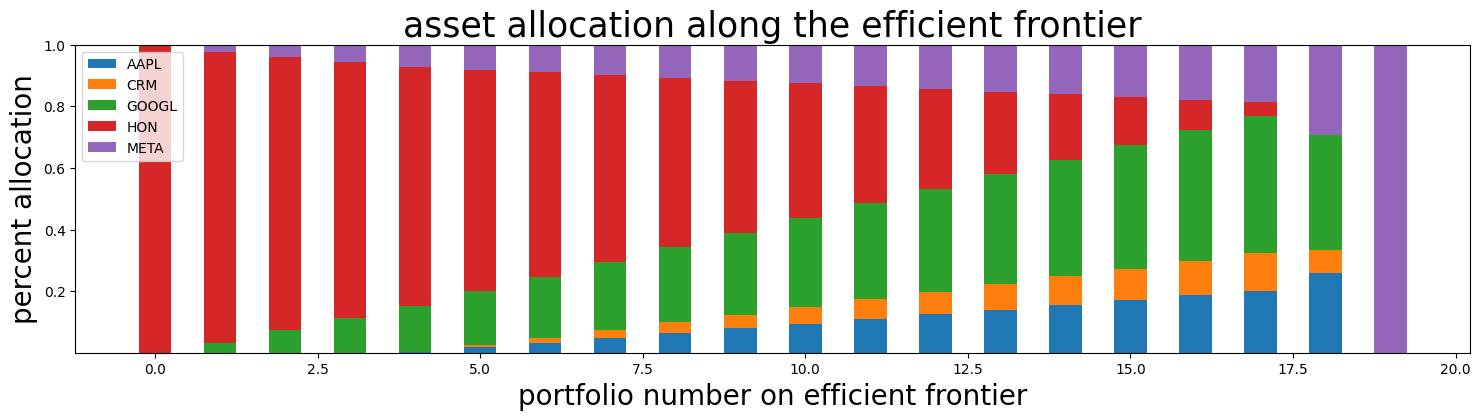

In [16]:
# create stacked bar plot showing security allocations for portfolios on the efficient frontier 

plt.figure(figsize=(18,4))
ind, width = range(len(frontier_pf)), .5  # number of portfolios, the width of each bar in the plot

# loop through portfolios on the efficient frontier

cumulative = [0.] * frontier_pf.shape[0]
for t in frontier_pf.columns:
    plt.bar(ind, frontier_pf[t], width, bottom=cumulative, label=t)
    cumulative += frontier_pf[t]
    
plt.legend(loc='upper left')
plt.title("asset allocation along the efficient frontier", fontsize=25)
plt.ylabel("percent allocation", fontsize=20)
plt.xlabel("portfolio number on efficient frontier", fontsize=20)
plt.show()

# locate the min variance portfolio on the efficient frontier

minimum variance portfolio


,risk,return
10,0.240353,0.158554


,AAPL,CRM,GOOGL,HON,META
10,0.094134,0.054287,0.288845,0.437319,0.125414


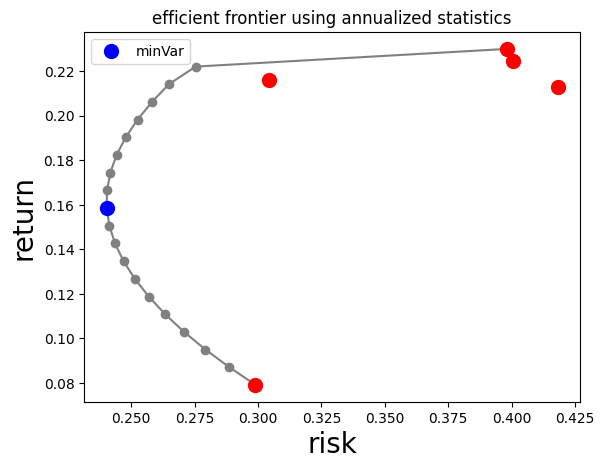

# Component beta
## composition and risk-return for minimum variance portfolio

,AAPL,CRM,GOOGL,HON,META
10,0.094134,0.054287,0.288845,0.437319,0.125414


,risk,return
10,0.240353,0.158554


(nan, nan)

# compute beta for a stock
## regress its returns on the portfolio (in this case min var) returns

,AAPL,CRM,GOOGL,HON,META,portfolio
Date,,,,,,
2000-01-04,-0.088077,NaN,NaN,-0.017798,NaN,NaN
2000-01-05,0.014527,NaN,NaN,-0.013560,NaN,NaN
2000-01-06,-0.090514,NaN,NaN,0.019155,NaN,NaN
2000-01-07,0.046281,NaN,NaN,0.052185,NaN,NaN
2000-01-10,-0.017745,NaN,NaN,0.005283,NaN,NaN


                            OLS Regression Results                            
Dep. Variable:                    CRM   R-squared:                       0.395
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     2085.
Date:                Thu, 06 Feb 2025   Prob (F-statistic):               0.00
Time:                        16:29:11   Log-Likelihood:                 8514.3
No. Observations:                3196   AIC:                        -1.702e+04
Df Residuals:                    3194   BIC:                        -1.701e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -3.117e-05      0.000     -0.104      0.9

'CRM beta = 1.0478'